In [1]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Visualization libraries
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker 

# Machine Learning libraries
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import average_precision_score


## Data loading

In [2]:
# Read the data
df = pd.read_csv("PS_20174392719_1491204439457_log.csv")

In [3]:
# Checking the first 5 rows of the data
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [4]:
# Checking the overall info about the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


## Data cleaning

In [5]:
# Checking for null values
df.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [6]:
# Checking duplicates
duplicates = df[df.duplicated()]

print("Duplicates found:")
print(duplicates)

Duplicates found:
Empty DataFrame
Columns: [step, type, amount, nameOrig, oldbalanceOrg, newbalanceOrig, nameDest, oldbalanceDest, newbalanceDest, isFraud, isFlaggedFraud]
Index: []


#### Data cleaning result:

The result of the data cleaning is that we dont have nulls or duplicates, so we can continue with the exploratory data analysis.

## Exploratory Data Analysis

First we are going to see the transactions types and which ones has fraud operations.

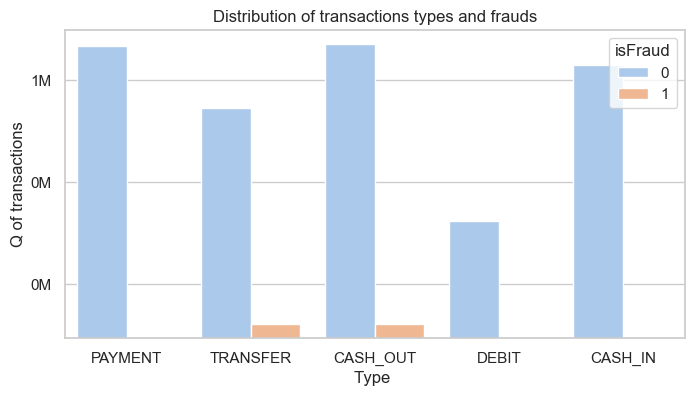

In [7]:
# Creation of bar plot with the transactions types
def countplot_eda(df):
    sns.set_style('whitegrid')
    sns.set_context('notebook')
    plt.figure(figsize=(8, 4))
    
    counplot = sns.countplot(data=df, x='type', hue='isFraud',palette= "pastel")
    counplot.set_xlabel('Type ')
    counplot.set_ylabel(f'Q of transactions')
    counplot.set_yscale('log')
    
    counplot.yaxis.set_major_formatter(mticker.FuncFormatter(lambda x, _: '{:,.0f}'.format(x/1e6) + 'M'))

    plt.title('Distribution of transactions types and frauds')
    plt.show()

countplot_eda(df)

In [8]:
# Identify the types of the fraud transactions
print('\n The types of fraudulent transactions are {}'.format(\
list(df.loc[df.isFraud == 1].type.drop_duplicates().values)))

dfFraudTransfer = df.loc[(df.isFraud == 1) & (df.type == 'TRANSFER')]
dfFraudCashout = df.loc[(df.isFraud == 1) & (df.type == 'CASH_OUT')]

print ('\n The number of fraudulent TRANSFERs = {}'.\
       format(len(dfFraudTransfer)))

print ('\n The number of fraudulent CASH_OUTs = {}'.\
       format(len(dfFraudCashout)))


 The types of fraudulent transactions are ['TRANSFER', 'CASH_OUT']

 The number of fraudulent TRANSFERs = 4097

 The number of fraudulent CASH_OUTs = 4116


In [9]:
non_fraudulent_transactions = df[df['isFraud'] == 0]
fraudulent_transactions = df[df['isFraud'] == 1]

# Amount format
def format_amount(amount):
    if amount >= 1e6:
        return '${:,.2f}M'.format(amount * 1e-6)
    elif amount >= 1e3:
        return '${:,.2f}K'.format(amount * 1e-3)
    else:
        return '${:,.2f}'.format(amount)

# Media calculation
non_fraudulent_mean = non_fraudulent_transactions['amount'].mean()
formatted_non_fraudulent_mean = format_amount(non_fraudulent_mean)

fraudulent_mean = fraudulent_transactions['amount'].mean()
formatted_fraudulent_mean = format_amount(fraudulent_mean)

print(f"Mean of non-fraudulent transactions: {formatted_non_fraudulent_mean}")
print(f"Mean of fraudulent transactions: {formatted_fraudulent_mean}")

Mean of non-fraudulent transactions: $178.20K
Mean of fraudulent transactions: $1.47M


In this point we can see that the mean of the fraudulent transactions are almost 8 times bigger than the other ones. This can help us in the future to identify the possibles fraudulent transactions.

In [10]:
# Count the number of occurrences of each value in the 'isFraud' column
fraud_counts = df['isFraud'].value_counts()

# Calculate the percentage of fraud and non-fraud cases
fraud_percentage = (fraud_counts[1] / len(df)) * 100
non_fraud_percentage = (fraud_counts[0] / len(df)) * 100

print("Fraud percentage:", round(fraud_percentage,5),"%")
print("Non-fraud percentage:", round(non_fraud_percentage,5),"%")

Fraud percentage: 0.12908 %
Non-fraud percentage: 99.87092 %


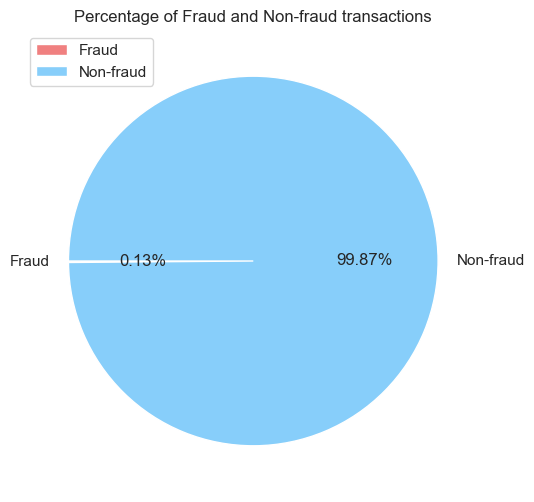

In [11]:
labels = ['Fraud', 'Non-fraud']
sizes = [fraud_percentage, non_fraud_percentage]
colors = ['lightcoral', 'lightskyblue']


# Creation of pie chart with the fraud and non-fraud transactions
plt.figure(figsize=(6, 6))
plt.pie(sizes, labels=labels, autopct='%1.2f%%', colors=colors, startangle=180)
plt.legend(loc='upper left',labels=['Fraud','Non-fraud'])

plt.title('Percentage of Fraud and Non-fraud transactions')
plt.show()

In [12]:
# Calculate the percentage of the fraud transactions flagged as fraud
fraudulent_transactions = df[df['isFraud'] == 1]
fraudulent_flagged_percentage = fraudulent_transactions['isFlaggedFraud'].value_counts(normalize=True) * 100

print("Percentage of fraudulent transactions flagged as fraudulent:")
print(fraudulent_flagged_percentage)

Percentage of fraudulent transactions flagged as fraudulent:
isFlaggedFraud
0    99.805187
1     0.194813
Name: proportion, dtype: float64


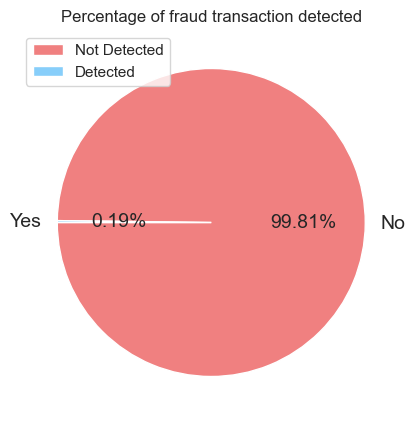

In [13]:
fraud = df.loc[df.isFraud == 1]

fraud.loc[:, 'isFlaggedFraud'] = fraud['isFlaggedFraud'].replace({1: 'Yes', 0: 'No'})


# Creation of pie chart with the comparation of the fraud and non-fraud transaction detected by the fraud flag
piedata = fraud.groupby(['isFlaggedFraud']).sum()


f, axes = plt.subplots(1,1, figsize=(5,5))
axes.set_title("Percentage of fraud transaction detected")
piedata.plot(kind='pie',y='isFraud',ax=axes, fontsize=14,colors=colors,shadow=False,autopct='%1.2f%%',startangle=180 );
axes.set_ylabel('');
plt.legend(loc='upper left',labels=['Not Detected','Detected'])
plt.show()

This means that the flagged fraud only worked for 0,19% of real fraud transactions, but it didnt worked for the other 99,8%. This number is alerting and is telling us that the flag is not working correctly.

In [14]:
fraudulent_transactions = df[df['isFraud'] == 1]

# Identify users who have participated in fraudulent transactions
fraudulent_users = set(fraudulent_transactions['nameOrig'])

# Filter non-fraudulent transactions performed by users identified as fraudulent
non_fraudulent_after_fraud = df[(df['nameOrig'].isin(fraudulent_users)) & (df['isFraud'] == 0)]

# Count the number of unique users who met the criteria
num_unique_users_after_fraud = non_fraudulent_after_fraud['nameOrig'].nunique()

# Display the count of unique users who met the criteria
print("Number of origin accounts that made both non-fraudulent and fraudulent transactions:", num_unique_users_after_fraud)

Number of origin accounts that made both non-fraudulent and fraudulent transactions: 28


In [15]:
# Identify users who have participated in fraudulent transactions
fraudulent_users = set(fraudulent_transactions['nameDest'])

# Filter non-fraudulent transactions performed by users identified as fraudulent
non_fraudulent_after_fraud = df[(df['nameDest'].isin(fraudulent_users)) & (df['isFraud'] == 0)]

# Count the number of unique users who met the criteria
num_unique_users_after_fraud = non_fraudulent_after_fraud['nameDest'].nunique()

# Display the count of unique users who met the criteria
print("Number of destination accounts that made both non-fraudulent and fraudulent transactions:", num_unique_users_after_fraud)

Number of destination accounts that made both non-fraudulent and fraudulent transactions: 5492


In [16]:
# Group by the nameOrig field and count the number of fraudulent transactions for each user
fraudulent_transactions_count = fraudulent_transactions.groupby('nameOrig').size()

# Filter only those users who have more than one fraudulent transaction
users_with_multiple_fraudulent_transactions = fraudulent_transactions_count[fraudulent_transactions_count > 1]

print("Users with more than one fraudulent transaction:")
print(users_with_multiple_fraudulent_transactions.index.tolist())

Users with more than one fraudulent transaction:
[]


None of the users have made more than one fraudulent transaction.






In [17]:
# Get the list of users who have performed fraudulent transactions
users_with_fraudulent_transactions = set(fraudulent_transactions['nameOrig'])

# Filter non-fraudulent transactions performed by the same users
non_fraudulent_transactions = df[(df['nameOrig'].isin(users_with_fraudulent_transactions)) & (df['isFraud'] == 0)]

# Get the final list of users who have performed both fraudulent and non-fraudulent transactions
users_with_both_transactions = set(non_fraudulent_transactions['nameOrig'])

count_users_with_both_transactions = len(users_with_both_transactions)

print("List of users:", users_with_both_transactions)

List of users: {'C1885333477', 'C1851065642', 'C471097879', 'C1044518032', 'C483009518', 'C570470570', 'C1882162040', 'C432562518', 'C1863683348', 'C812001868', 'C1498185758', 'C876181265', 'C1127304441', 'C357911107', 'C635739031', 'C1627918307', 'C1899367925', 'C10982843', 'C850961884', 'C803411135', 'C1118399210', 'C686187434', 'C2004363483', 'C1191696703', 'C929585215', 'C171834973', 'C431038121', 'C1015856166'}


In [18]:
# Filtered dataset of users who have performed both fraudulent and non-fraudulent transactions

filtered_df = df[df['nameOrig'].isin(users_with_both_transactions)]

# Identify users who performed a fraudulent transaction before a non-fraudulent one
users_with_fraudulent_before_non_fraudulent = set()

for user in users_with_fraudulent_transactions:
    user_transactions = filtered_df[filtered_df['nameOrig'] == user].sort_values(by='step')
    
    fraudulent_indices = user_transactions[user_transactions['isFraud'] == 1].index
    non_fraudulent_indices = user_transactions[user_transactions['isFraud'] == 0].index

# Check if theres at least one fraudulent transaction before a non-fraudulent one
    if not fraudulent_indices.empty and not non_fraudulent_indices.empty and fraudulent_indices.min() < non_fraudulent_indices.min():
        users_with_fraudulent_before_non_fraudulent.add(user)

# Display the list of users who performed a fraudulent transaction before a non-fraudulent one
print("Users who performed a fraudulent transaction before a non-fraudulent one:", users_with_fraudulent_before_non_fraudulent)
print("Quantity of users:",len(users_with_fraudulent_before_non_fraudulent))

Users who performed a fraudulent transaction before a non-fraudulent one: {'C635739031', 'C1118399210', 'C1627918307', 'C686187434', 'C432562518', 'C1863683348', 'C10982843', 'C171834973', 'C431038121', 'C570470570'}
Quantity of users: 10


We have identified a concerning pattern where 10 accounts have executed a non-fraudulent transaction immediately following a fraudulent one. This poses a high risk, as there is uncertainty about the authenticity of transactions flagged as non-fraudulent. There is a possibility that these transactions might be fraudulent, and we may not have detected them. Considering this, we recommend blocking these accounts to mitigate potential risks and conduct further investigation to ensure the security of our system. Let's see how much money are worth.

In [19]:
# Calculating the total amount of non-fraud transactions maded after a fraud transaction

critical_users_df = filtered_df[filtered_df['nameOrig'].isin(users_with_fraudulent_before_non_fraudulent)]

critical_users_df = critical_users_df[critical_users_df['isFraud'] == 0]

total_amount = critical_users_df['amount'].sum()
print("Total Amount:", total_amount)

Total Amount: 1568246.77


Based on this analysis, it has been determined that nearly €1.56 million was transacted after these accounts engaged in fraudulent transactions.

As we know, the field step represents a unit of time, and this dataset is a sample covering one month of transactions. I will assume that this simulation corresponds to the month of January of this year.

With 744 steps, where each step corresponds to 1 hour, the dataset effectively represents a sample of 31 days.

Given this clarification, I will analyze when fraudulent transactions are more common.

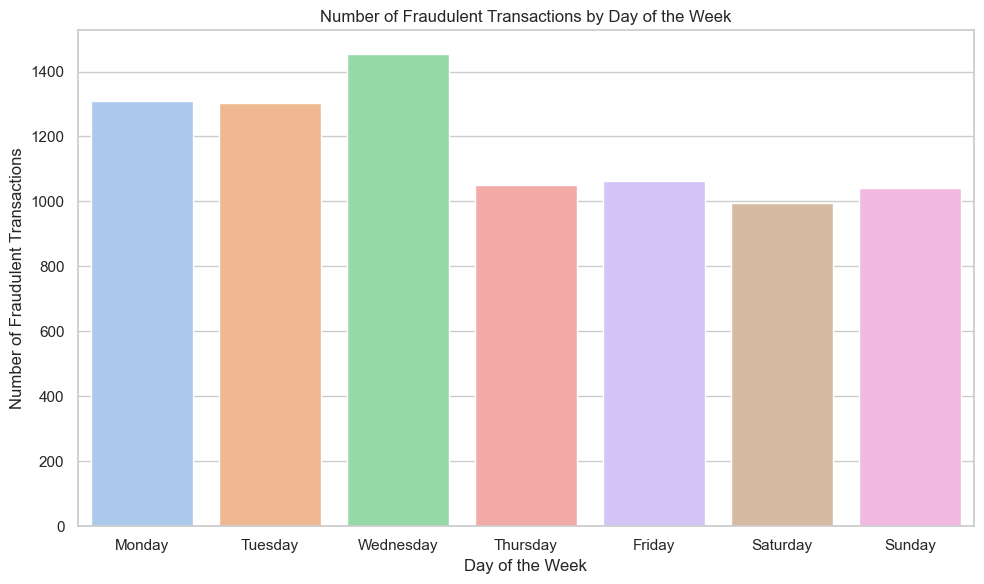

In [20]:
# Convert 'step' to a timestamp and extract the day of the week, also the hour for the next analysis
fraud_df = df[df['isFraud'] == 1].copy()  # Crear una copia explícita
fraud_df['timestamp'] = fraud_df['step'].apply(lambda step: datetime(2024, 1, 1) + timedelta(hours=step))
fraud_df['day_of_week'] = fraud_df['timestamp'].dt.day_name()

# Plot the number of fraudulent transactions by day of the week
plt.figure(figsize=(10, 6))
sns.countplot(x='day_of_week', data=fraud_df, order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], palette='pastel')
plt.title('Number of Fraudulent Transactions by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Fraudulent Transactions')
plt.tight_layout()
plt.show()

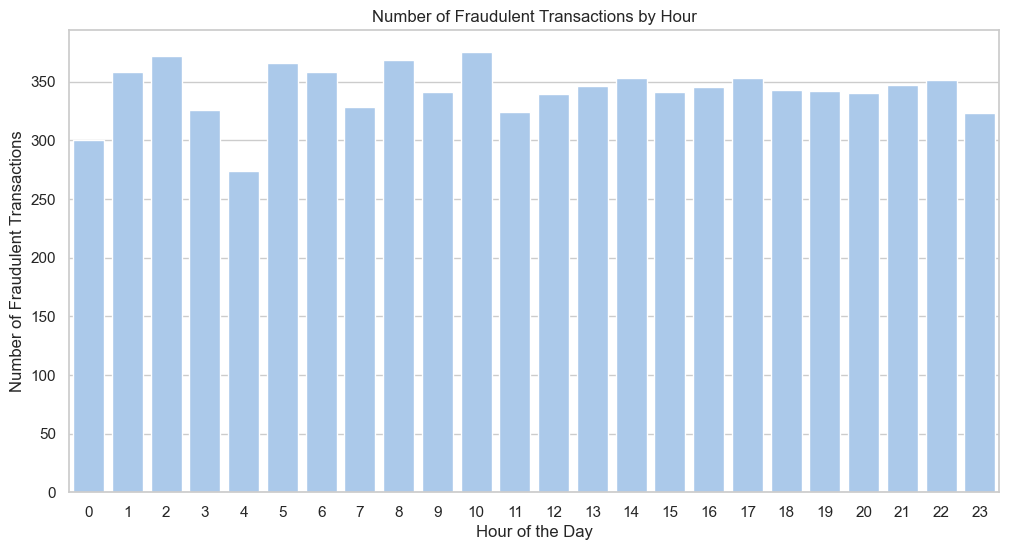

In [21]:
fraud_df['hour'] = fraud_df['timestamp'].dt.hour

color = sns.color_palette('pastel')[0] 

# Plot the number of fraudulent transactions by hour
plt.figure(figsize=(12, 6))
sns.set(style='whitegrid')  
sns.countplot(x='hour', data=fraud_df, color=color)
plt.title('Number of Fraudulent Transactions by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Fraudulent Transactions')
plt.show()

#### Exploratory Data Analysis insights:

With this analysis, we discovered the following insights:

* The fraudulent transactions types are Transfer and Cash out.
* There are a total of 8,213 fraudulent transactions, constituting 0.12908% of the total transactions.
* The mean transaction amount for non-fraudulent transactions is €178.20K. In contrast, the mean transaction amount for fraudulent transactions is €1.47M, nearly 8 times higher. This significant difference suggests the potential for implementing additional verification steps for transactions exceeding €1M.
* The fraud flag only correctly identified 0.19% of the actual fraudulent transactions. This low accuracy raises concerns about its reliability and suggests the need for an improved detection mechanism.
* 28 accounts have been involved in both fraudulent and non-fraudulent transactions. Notably, 10 accounts made a non-fraudulent transaction after a fraudulent one, totaling €1.56M. This poses a high risk, and prompt account blocking is recommended once a fraudulent transaction is detected.
* No user has engaged in more than one fraudulent transaction.
* Fraudulent transactions are slightly more common on Wednesdays.
* There is no evidence indicating that fraudulent transactions occur at specific hours.

### Prediction of fraudulent transactions:

As the fraudulent flag doesnt work as we need, Im going to develope a machine learning model to predict this type of transactions. 

In [22]:
### Encoding the transfer types 
df_ml = df.replace(to_replace={'PAYMENT':1,'TRANSFER':2,'CASH_OUT':3,
                                            'CASH_IN':4,'DEBIT':5})
# Splitting the dataset into features (X) and target variable (y)
X = df_ml.drop(['isFraud', 'nameOrig', 'nameDest'], axis=1)
y = df_ml['isFraud'].values.ravel()

# Splitting the dataset into training and testing sets
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=121, stratify=y)

# Initializing the RandomForest classifier with 15 estimators
clf = RandomForestClassifier(n_estimators=15, random_state=121)

# Training the model and predicting probabilities on the test set
if True:
    probabilities = clf.fit(train_X, train_y).predict_proba(test_X)[:, 1]

# Evaluating the model using the average precision score metric
if True:
    print("Average Precision Score:", average_precision_score(test_y, probabilities))


Average Precision Score: 0.9038504107828255


### Machine Learning model insights:

* The average precision score for this model is 90%. In comparison with the actual fraud flag (0.19%), we are improving the prediction of fraudulent transactions, demonstrating a significantly higher accuracy and reliability in identifying potential fraud cases.
* The actual fraud flag must be reviewed and improved, or we can face potential loss of huge amounts of money and facilitate money laundering
* This model has been constructed using the information available in the dataset. Incorporating details such as the account creation date, transaction volume associated with each account, currency information, user behavior, and a history of transactions flagged as suspicious would provide a more comprehensive foundation for robust and accurate fraud detection in practical scenarios.